## Assignment 1: Gaussian Elimination

In [1]:
import numpy as np
from numpy.linalg import norm, cond
from numpy.random import seed
from scipy.linalg import toeplitz, inv, solve, lu_solve, solve_triangular
import time
import matplotlib.pyplot as plt
import pandas as pd

## Question 1

In this section Partial and Complete pivoting methods are implemented.

### Partial Pivoting

Method gets a nxn matrix A as input and returns three matrices L, U, P such as PA = LU.

In [2]:
def gauss_pp(A):
    #validity of input check
    assert A.shape[0]==A.shape[1]
    
    #copy A matrix to Ac to preserve A
    Ac = np.copy(A)
    
    #rows/columns of A
    n = Ac.shape[0]
    
    #permutation vector p and permutation table P initialization
    p = np.arange(0,n)
    P = np.eye(n)
    
    for i in range(n):
        #find pivot point(rows to be swaped)
        pivot_point = np.argmax(abs(Ac[i:,i]))+i
        
        #swap rows in table A and permutation vector
        Ac[[i, pivot_point]] = Ac[[pivot_point, i]]
        p[[i, pivot_point]] = p[[pivot_point, i]]
        
        #update L part of table A
        Ac[i+1:,i] = Ac[i+1:,i]/Ac[i][i]
        #update U part of table A
        #Ac[i+1:,i+1:] = Ac[i+1:,i+1:] - np.dot(Ac[i+1:,i].reshape((n-i-1,1)), Ac[i,i+1:].reshape((1,n-i-1)))
        Ac[i+1:,i+1:] = Ac[i+1:,i+1:] - np.outer(Ac[i+1:,i], Ac[i,i+1:])

    L = np.tril(Ac,-1) + np.eye(n)
    U = np.triu(Ac)
    
    return L, U, P[p,:]

### Complete Pivoting

Method gets a nxn matrix A as input and returns four matrices L, U, P,Q such as PAQ = LU.

In [3]:
def gauss_cp(A):
    
    #validity of input check
    assert A.shape[0]==A.shape[1]
    
    #copy A matrix to Ac to preserve A
    Ac = np.copy(A)
    
    #rows/columns of A
    n = Ac.shape[0]
    
    #permutation vectors p(rows) and q(columns) and permutation tables P(rows) and Q(columns) initialization
    p = np.arange(0,n)
    q = np.arange(0,n)
    P = np.eye(n)
    Q = np.eye(n)
   
    for i in range(n):
        
        #position of largest element
        row, col = np.argmax(np.max(abs(Ac[i:,i:]), axis = 1))+i, np.argmax(np.max(abs(Ac[i:,i:]), axis = 0))+i
        
        #swap rows and columns to bring the largest element up
        Ac[[i, row],:] = Ac[[row, i],:]
        Ac[:,[i, col]] = Ac[:,[col,i]]
        
        #update permutation vectors
        p[[i, row]] = p[[row, i]]
        q[[i, col]] = q[[col, i]]
        
        #update L part of table A
        Ac[i+1:,i] = Ac[i+1:,i]/Ac[i][i]
        #update U part of table A
        #Ac[i+1:,i+1:] = Ac[i+1:,i+1:] - np.dot(Ac[i+1:,i].reshape((n-i-1,1)), Ac[i,i+1:].reshape((1,n-i-1)))
        Ac[i+1:,i+1:] = Ac[i+1:,i+1:] - np.outer(Ac[i+1:,i], Ac[i,i+1:])

        
    L = np.tril(Ac,-1) + np.eye(n)
    U = np.triu(Ac)
    
    return L, U, P[p,:], Q[:,q]

## Question 2

Create Toeplitz matrix for n = 64, 128, 256, 1024, by computing a row of length n based on the given sequence and then using the scipy built in function that creates a Toeplitz matrix. 

In [4]:
def toeplitz_matrix(n):
    pi = np.pi
    A_t = [(pi**4)/5]
    for k in range(1, n):
        A_k = (4*((-1)**k)*((pi**2)*(k**2)-6))/k**4
        A_t = np.append(A_t, [A_k])
    return toeplitz(A_t, A_t)

Generate linear systems based on Toeplitz matrices. A vector x is generated randomly and then b (= Ax) is computed.

In [5]:
def linear_system(A):
    seed(123)
    x = np.random.randn(A.shape[0], 1)
    b = np.dot(A,x)
    return A,x,b

* Partial Pivoting: $A = P^TLU$ since for permutation matrices $P^{-1}=P^T$

$Ax = b$

$P^TLUx = b$

$LUx = Pb$

Set $y = Ux$. Then $Ly = Pb$. Solve the two systems to get x.

In [6]:
N = [64, 128, 256, 512, 1024]
error_partial = []
residual_partial = []
CPUtime_partial = []
cond_num = []

In [7]:
for n in N:
    #create system
    A,x,b = linear_system(toeplitz_matrix(n))
    #start timer
    start = time.time()
    #apply gaussian elimination to A matrix
    L,U,P = gauss_pp(A)
    #solve systems
    y = solve(L,np.dot(P,b))
    x_ = solve(U,y)
    #end timer
    end = time.time()
    #keep time elapsed in a list
    CPUtime_partial.append(np.round(end-start, 5))  
    #error computation
    error_partial.append(norm(x_-x, ord=np.inf)) 
    residual_partial.append(norm(b-A@x_, ord=np.inf))
    #condition number computation
    cond_num.append(cond(A, p=np.inf))

* Complete Pivoting: $A = P^TLUQ^T$ since for permutation matrices $P^{-1}=P^T$

$Ax = b$

$P^TLUQ^Tx = b$

$LUQ^Tx = Pb$

Set $y = Q^Tx$, $Uy = z$ and $Lz = Pb$. Solve the three systems to get x.

In [8]:
N = [64, 128, 256, 512, 1024]
error_complete = []
residual_complete = []
CPUtime_complete = []
cond_complete = []

In [9]:
for n in N:
    #create system
    A,x,b = linear_system(toeplitz_matrix(n))
    #start timer
    start = time.time()
    #apply gaussian elimination to A matrix
    L,U,P,Q = gauss_cp(A)
    #solve systems
    z = solve(L,np.dot(P,b))
    y = solve(U,z)
    x_ = solve(Q.T, y)
    #end timer
    end = time.time()    
    #keep time elapsed in a list
    CPUtime_complete.append(np.round(end-start, 5))
    #error computation
    error_complete.append(norm(x_-x, ord=np.inf))
    residual_complete.append(norm(b-A@x_, ord=np.inf))

In [10]:
print('Infinity Norms of Errors and Condition Numbers')
print('-'*125)
fmt = '{:<7}{:<25}{:<25}{:<25}{:<25}{}'
print(fmt.format('n', 'Partial Error', 'Complete Error', 'Residual Partial', 'Residual Complete', 'Condition Number'))
print('-'*125)
for n in range(len(N)):
    print(fmt.format(N[n],
                     error_partial[n],
                     error_complete[n],
                     residual_partial[n],
                     residual_complete[n],
                     np.round(cond_num[n],4)))

Infinity Norms of Errors and Condition Numbers
-----------------------------------------------------------------------------------------------------------------------------
n      Partial Error            Complete Error           Residual Partial         Residual Complete        Condition Number
-----------------------------------------------------------------------------------------------------------------------------
64     7.521794298526174e-11    9.466205597163935e-11    3.197442310920451e-14    3.552713678800501e-14    4550789.9329
128    9.39581523695665e-10     1.8223194064859172e-09   7.105427357601002e-14    4.973799150320701e-14    70460126.5698
256    5.708019640282558e-09    9.262127953491017e-09    1.0658141036401503e-13   8.526512829121202e-14    1108456878.8501
512    2.108450097293435e-07    3.151315490779183e-07    1.1368683772161603e-13   1.1368683772161603e-13   17583765297.8573
1024   3.870123418459048e-06    1.7517906463204724e-06   2.1316282072803006e-13   1.42108

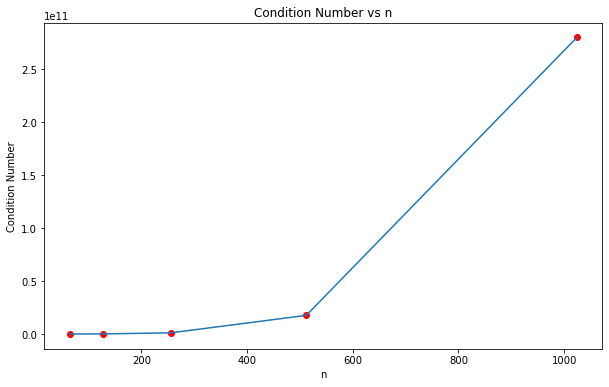

In [11]:
plt.figure(figsize=(10,6))
plt.title('Condition Number vs n')
plt.plot(N, cond_num)
plt.scatter(N, cond_num, c='r')
plt.xlabel('n')
plt.ylabel('Condition Number')
plt.show()

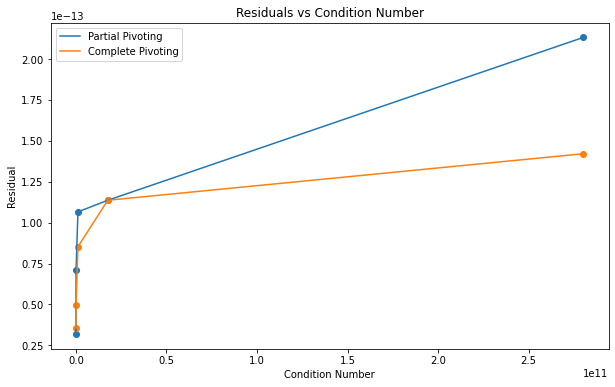

In [12]:
df = pd.DataFrame({'Partial Pivoting':residual_partial, 'Complete Pivoting':residual_complete})
plt.figure(figsize=(10,6))
plt.title('Residuals vs Condition Number')
plt.plot(cond_num, df)
plt.scatter(cond_num, residual_partial)
plt.scatter(cond_num, residual_complete)
plt.legend(df.columns.values)
plt.xlabel('Condition Number')
plt.ylabel('Residual')
plt.show()

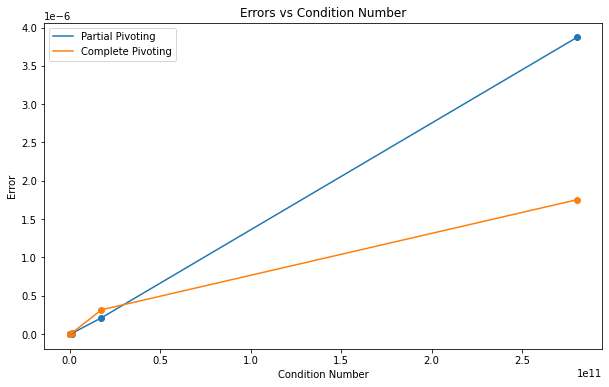

In [13]:
df = pd.DataFrame({'Partial Pivoting':error_partial, 'Complete Pivoting':error_complete})
plt.figure(figsize=(10,6))
plt.title('Errors vs Condition Number')
plt.plot(cond_num, df)
plt.scatter(cond_num, error_partial)
plt.scatter(cond_num, error_complete)
plt.legend(df.columns.values)
plt.xlabel('Condition Number')
plt.ylabel('Error')
plt.show()

Computations for n = 2048

In [14]:
n = 2048
#create system
A,x,b = linear_system(toeplitz_matrix(n))
#start timer
start = time.time()
#apply gaussian elimination to A matrix
L,U,P = gauss_pp(A)
#solve systems
y = solve(L,np.dot(P,b))
x_ = solve(U,y)
#end timer
end = time.time()
#keep time elapsed in a list
print('Partial Pivoting for n = 2048: \nTime elapsed: ', np.round(end-start, 2))
#error computation
print('Error for n = 2048: ', norm(x_-x, ord=np.inf))
print('Residual for n = 2048: ', norm(b-A@x_, ord=np.inf))
#condition number computation
print('Condition Number: ',cond(A, p=np.inf))

Partial Pivoting for n = 2048: 
Time elapsed:  33.23
Error for n = 2048:  0.00014236314544080475
Residual for n = 2048:  3.836930773104541e-13
Condition Number:  4472303338839.957


In [15]:
n = 2048
#create system
A,x,b = linear_system(toeplitz_matrix(n))
#start timer
start = time.time()
#apply gaussian elimination to A matrix
L,U,P,Q = gauss_cp(A)
#solve systems
z = solve(L,np.dot(P,b))
y = solve(U,z)
x_ = solve(Q.T, y)
#end timer
end = time.time()    
#keep time elapsed in a list
print('Complete Pivoting for n = 2048: \nTime elapsed: ', np.round(end-start, 2))
#error computation
print('Error for n = 2048: ', norm(x_-x, ord=np.inf))
print('Residual for n = 2048: ', norm(b-A@x_, ord=np.inf))

Complete Pivoting for n = 2048: 
Time elapsed:  70.63
Error for n = 2048:  3.6749981182568336e-05
Residual for n = 2048:  1.8474111129762605e-13


## Question 3

In this setion, the CPU run times (computed in previous question), of both methods implemented in question 1, are presented for the different values of n.

In [16]:
print('CPU run times')
print('-'*35)
fmt = '{:<7}{:<15}{}'
print(fmt.format('n', 'Partial Time', 'Complete Time'))
print('-'*35)
for n in range(len(N)):
    print(fmt.format(N[n], CPUtime_partial[n], CPUtime_complete[n]))

CPU run times
-----------------------------------
n      Partial Time   Complete Time
-----------------------------------
64     0.00697        0.01196
128    0.01396        0.02195
256    0.03491        0.07779
512    0.34604        0.79887
1024   3.98041        8.79549


## Question 4

Create matrix with -1 in lower triangular part, 1 in main diagonal and last column.
Repeat experiments.

* Partial Pivoting

In [17]:
N = [64, 128, 256, 512, 1024]
error_partial =[]
residual_partial = []
CPUtime_partial = []
cond_num = []

In [18]:
np.set_printoptions(suppress=True)
for n in N:
    A = np.tril([-1]*n,-1) +np.eye(n)
    A[:,-1] = 1
    #create system
    A,x,b = linear_system(A)
    #start timer
    start = time.time()
    #apply gaussian elimination to A matrix
    L,U,P = gauss_pp(A)
    #solve systems
    y = solve(L,np.dot(P,b))
    x_ = solve(U,y)
    #end timer
    end = time.time()
    #keep time elapsed in a list
    CPUtime_partial.append(np.round(end-start, 5))  
    #error computation
    error_partial.append(norm(x_-x, ord=np.inf))
    residual_partial.append(norm(b-A@x_, ord=np.inf))
    #condition number computation
    cond_num.append(cond(A, p=np.inf))

<ipython-input-18-0df5ad616d23>:12: LinAlgWarning: Ill-conditioned matrix (rcond=1.69407e-21): result may not be accurate.
  y = solve(L,np.dot(P,b))
<ipython-input-18-0df5ad616d23>:13: LinAlgWarning: Ill-conditioned matrix (rcond=5.42101e-20): result may not be accurate.
  x_ = solve(U,y)
<ipython-input-18-0df5ad616d23>:12: LinAlgWarning: Ill-conditioned matrix (rcond=4.59177e-41): result may not be accurate.
  y = solve(L,np.dot(P,b))
<ipython-input-18-0df5ad616d23>:13: LinAlgWarning: Ill-conditioned matrix (rcond=2.93874e-39): result may not be accurate.
  x_ = solve(U,y)
<ipython-input-18-0df5ad616d23>:12: LinAlgWarning: Ill-conditioned matrix (rcond=6.74701e-80): result may not be accurate.
  y = solve(L,np.dot(P,b))
<ipython-input-18-0df5ad616d23>:13: LinAlgWarning: Ill-conditioned matrix (rcond=8.63617e-78): result may not be accurate.
  x_ = solve(U,y)
<ipython-input-18-0df5ad616d23>:12: LinAlgWarning: Ill-conditioned matrix (rcond=2.91341e-157): result may not be accurate.
  y

* Complete Pivoting

In [19]:
N = [64, 128, 256, 512, 1024]
error_complete =[]
residual_complete = []
CPUtime_complete = []

In [20]:
for n in N:
    A = np.tril([-1]*n,-1) +np.eye(n)
    A[:,-1] = 1
    #create system
    A,x,b = linear_system(A)
    #start timer
    start = time.time()
    #apply gaussian elimination to A matrix
    L,U,P,Q = gauss_cp(A)
    #solve systems
    z = solve(L,np.dot(P,b))
    y = solve(U,z)
    x_ = solve(Q.T, y)
    #end timer
    end = time.time()    
    #keep time elapsed in a list
    CPUtime_complete.append(np.round(end-start, 5))
    #error computation
    error_complete.append(norm(x_-x, ord=np.inf))
    residual_complete.append(norm(b-A@x_, ord=np.inf))

In [21]:
print('Infinity Norms of Errors and Condition Numbers')
print('-'*125)
fmt = '{:<7}{:<25}{:<25}{:<25}{:<25}{}'
print(fmt.format('n', 'Partial Error', 'Complete Error', 'Residual Partial', 'Residual Complete', 'Condition Number'))
print('-'*125)
for n in range(len(N)):
    print(fmt.format(N[n],
                     error_partial[n],
                     error_complete[n],
                     residual_partial[n],
                     residual_complete[n],
                     np.round(cond_num[n],4)))

Infinity Norms of Errors and Condition Numbers
-----------------------------------------------------------------------------------------------------------------------------
n      Partial Error            Complete Error           Residual Partial         Residual Complete        Condition Number
-----------------------------------------------------------------------------------------------------------------------------
64     1.7548861819811095       1.9984014443252818e-15   5.921702358583993        4.440892098500626e-15    64.0
128    1048573.87689965         2.1094237467877974e-15   2096136.11442891         6.217248937900877e-15    128.0
256    3.2310550079193123       2.3314683517128287e-15   10.375641824000626       1.2434497875801753e-14   256.0
512    3.2310550079193123       8.43769498715119e-15     30.062895271478986       2.842170943040401e-14    512.0
1024   1025.3262654599405       1.176836406102666e-14    2094.6204680340875       4.618527782440651e-14    1024.0


## Question 5

In this section, two random vectors will be generated and then divided by their l2 norm, giving vectors whose l2 norm is 1. Then their outer product will be added to A tables of question 2.

In [22]:
N = [64, 128, 256, 512, 1024]
error_partial =[]
residual_partial =[]
CPUtime_partial = []
cond_num = []

In [23]:
for n in N:
    #create u,v
    u = np.random.randn(n)
    u = u/norm(u)
    u = u.reshape(n,1)
    v = np.random.randn(n)
    v = v/norm(v)
    v = v.reshape(n,1)
    #create table A and add outer product of u,v
    A = toeplitz_matrix(n)
    #apply gaussian elimination to A matrix
    L,U,P = gauss_pp(toeplitz_matrix(n))
    #create table Anew by adding outer product of u,v to A
    Anew = A + u@v.T
    Anew,x,b = linear_system(Anew)

    #start timer
    start = time.time()
    
    #invert A
    Ainv=inv(U)@(inv(L)@P)
    
    #calculate x_
    Anew_inv = Ainv-Ainv@u@v.T@Ainv/(1+v.T@Ainv@u)[0]
    x_=Anew_inv@b
        
    #end timer
    end = time.time()
    #keep time elapsed in a list
    CPUtime_partial.append(np.round(end-start, 5))  
    #error computation
    error_partial.append(norm(x-x_, ord=np.inf))
    residual_partial.append(norm(b-Anew@x_, ord=np.inf))   
    #condition number computation
    cond_num.append(cond(A, p=np.inf))

In [24]:
print('Infinity Norms of Errors, CPU Times and Condition Numbers')
print('-'*75)
fmt = '{:<7}{:<25}{:<25}{}'
print(fmt.format('n', 'Partial Error', 'Partial Residual', 'CPU Time', 'Condition Number'))
print('-'*75)
for n in range(len(N)):
    print(fmt.format(N[n],
                     error_partial[n],
                     residual_partial[n],
                     CPUtime_partial[n],
                     np.round(cond_num[n],4)))

Infinity Norms of Errors, CPU Times and Condition Numbers
---------------------------------------------------------------------------
n      Partial Error            Partial Residual         CPU Time
---------------------------------------------------------------------------
64     8.493361569605895e-11    3.018055139136777e-09    0.00398
128    3.0004188023013967e-09   6.445382183528636e-08    0.01097
256    2.4725397063107835e-08   5.703380310251305e-07    0.02194
512    1.7403738770682686e-06   3.449538043298617e-05    0.06483
1024   7.355887660098759e-06    0.00020436128597367542   0.22039
